# Lake Erie Surface Temperature Analysis
## Project Blue Nexus — Oceanographic Data Pipeline

**Author:** Ryan Jones  
**Date:** February 2026  
**Objective:** Build an automated pipeline to fetch, process, and visualize Sea Surface Temperature (SST) data for Lake Erie using NOAA's ERDDAP data service.

### Why Lake Erie?
Lake Erie is the shallowest and warmest of the Great Lakes, making it particularly sensitive to temperature changes. Rising surface temperatures are directly linked to harmful algal blooms (HABs) that threaten drinking water for millions of residents. Understanding SST patterns is the first step toward monitoring and predicting these events.

---

In [1]:
# Core scientific libraries
import time
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import requests
import warnings
import logging
warnings.filterwarnings('ignore')

# Ensure output directories exist
os.makedirs('../data', exist_ok=True)
os.makedirs('output', exist_ok=True)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

print("All libraries loaded successfully")
print(f"xarray version: {xr.__version__}")
print(f"cartopy version: {cartopy.__version__}")

All libraries loaded successfully
xarray version: 2025.6.1
cartopy version: 0.25.0


## Step 1: Fetching SST Data from NOAA ERDDAP

ERDDAP (Environmental Research Division Data Access Program) is NOAA's standardized data server. It provides oceanographic and environmental datasets through a REST API — meaning we can construct a URL that describes exactly what data we want (variable, region, time range) and download it directly as a NetCDF file.

**Dataset:** NOAA Great Lakes Surface Environmental Analysis (GLSEA)  
**Variable:** Lake Surface Temperature  
**Region:** Lake Erie (41.3°N to 42.9°N, -83.5°W to -78.8°W)

In [2]:
# Define Lake Erie bounding box
LAKE_ERIE = {
    'lat_min': 41.3,
    'lat_max': 42.9,
    'lon_min': -83.5,
    'lon_max': -78.8,
    'name': 'Lake Erie'
}

# NOAA ERDDAP - Great Lakes Surface Environmental Analysis (GLSEA)
# Server: apps.glerl.noaa.gov | Dataset: GLSEA_GCS
# Variable: sst | Daily resolution, ~1.4km grid | Available: 1995-2023

months = [
    ("2023-06-01", "2023-06-30", "June"),
    ("2023-07-01", "2023-07-31", "July"),
    ("2023-08-01", "2023-08-31", "August"),
    ("2023-09-01", "2023-09-30", "September"),
]

datasets = []
for start, end, name in months:
    filename = f"../data/lake_erie_sst_2023_{name.lower()}.nc"

    if os.path.exists(filename) and os.path.getsize(filename) > 1000:
        print(f"{name} 2023: Loading from cache...", end=" ")
        ds_month = xr.open_dataset(filename, engine="netcdf4")
        datasets.append(ds_month)
        print(f"OK ({len(ds_month.time)} days)")
        continue

    url = (
        "https://apps.glerl.noaa.gov/erddap/griddap/GLSEA_GCS.nc"
        "?sst"
        f"[({start}T12:00:00Z):1:({end}T12:00:00Z)]"
        f"[({LAKE_ERIE['lat_min']}):1:({LAKE_ERIE['lat_max']})]"
        f"[({LAKE_ERIE['lon_min']}):1:({LAKE_ERIE['lon_max']})]"
    )

    for attempt in range(1, 4):
        try:
            print(f"Fetching {name} 2023 (attempt {attempt}/3)...", end=" ")
            resp = requests.get(url, timeout=300)
            if resp.status_code == 200 and b'<!DOCTYPE' not in resp.content[:100]:
                with open(filename, "wb") as f:
                    f.write(resp.content)
                ds_month = xr.open_dataset(filename, engine="netcdf4")
                datasets.append(ds_month)
                print(f"OK ({len(resp.content)/1024:.0f} KB, {len(ds_month.time)} days)")
                break
            else:
                print(f"Bad response (status {resp.status_code})")
        except requests.exceptions.Timeout:
            print("Timeout.")
            if attempt < 3:
                print("  Retrying in 10s...", end=" ")
                time.sleep(10)

ds = xr.concat(datasets, dim="time")
print(f"\nDataset loaded: {len(ds.time)} days | {str(ds.time.values[0])[:10]} to {str(ds.time.values[-1])[:10]}")
print(f"Grid: {ds.sst.shape} | SST range: {float(ds.sst.min()):.1f}°C to {float(ds.sst.max()):.1f}°C")

June 2023: Loading from cache... OK (30 days)
July 2023: Loading from cache... OK (31 days)
August 2023: Loading from cache... OK (31 days)
September 2023: Loading from cache... OK (30 days)

Dataset loaded: 122 days | 2023-06-01 to 2023-09-30
Grid: (122, 115, 337) | SST range: 12.9°C to 27.0°C


## Step 2: Visualizing Lake Erie Surface Temperature

Now that we have 122 days of SST data, let's create our first map. We'll plot a single day's temperature field on a proper cartographic projection with coastlines, state borders, and a scientific colormap. This is the kind of figure you'd see in a research paper or NOAA bulletin.

Hottest day: 2023-08-04
Lake-wide average: 24.0°C


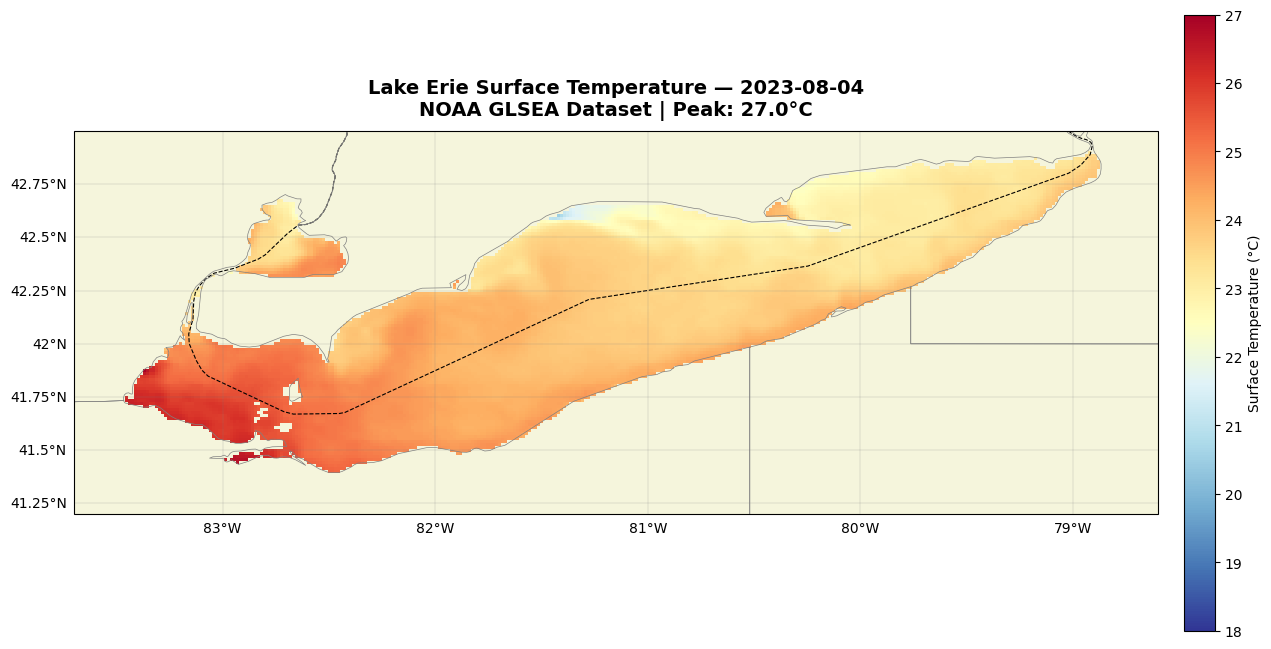


Saved: output/lake_erie_sst_peak_2023.png


In [3]:
# Plot SST for the hottest day in the dataset
# First, find which day had the highest average temperature
daily_mean = ds.sst.mean(dim=['latitude', 'longitude'])
hottest_day_idx = int(daily_mean.argmax())
hottest_day = ds.sst.isel(time=hottest_day_idx)
hottest_date = str(ds.time.values[hottest_day_idx])[:10]

print(f"Hottest day: {hottest_date}")
print(f"Lake-wide average: {float(daily_mean.isel(time=hottest_day_idx)):.1f}°C")

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(14, 8),
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Plot SST data
im = hottest_day.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=18, vmax=27,
    cbar_kwargs={
        'label': 'Surface Temperature (°C)',
        'shrink': 0.8,
        'pad': 0.02
    }
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1.2, color='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.8, linestyle='--')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='#F5F5DC', zorder=0)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Title
ax.set_title(f'Lake Erie Surface Temperature — {hottest_date}\n'
             f'NOAA GLSEA Dataset | Peak: {float(hottest_day.max()):.1f}°C',
             fontsize=14, fontweight='bold', pad=12)

# Set extent to Lake Erie
ax.set_extent([LAKE_ERIE['lon_min']-0.2, LAKE_ERIE['lon_max']+0.2,
               LAKE_ERIE['lat_min']-0.1, LAKE_ERIE['lat_max']+0.1])

plt.tight_layout()
plt.savefig('output/lake_erie_sst_peak_2023.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: output/lake_erie_sst_peak_2023.png")

## Step 3: Seasonal Temperature Curve

How did Lake Erie warm through summer 2023? By computing the lake-wide spatial average for each day, we can see the full warming arc from early June through late September. This is a fundamental analysis in limnology (the study of inland waters) — the seasonal temperature cycle drives everything from stratification to algal bloom timing.

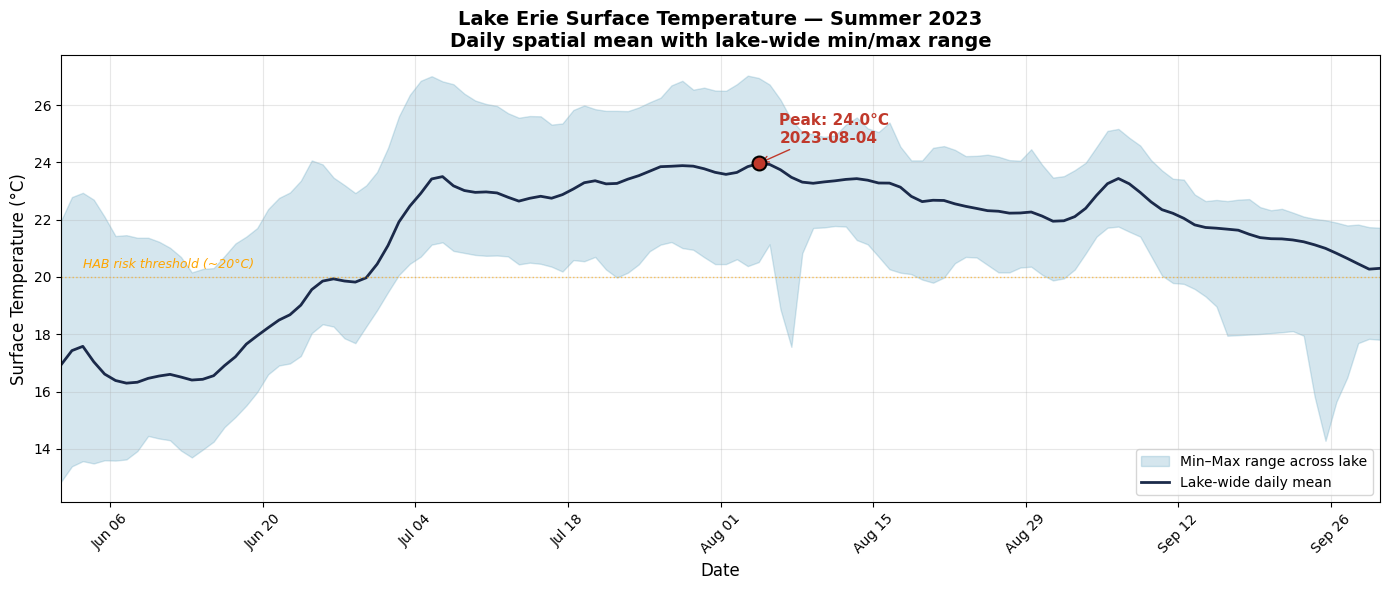

Temperature range: 16.3°C to 24.0°C
Days above 20°C (HAB risk): 93 of 122


In [4]:
# Compute daily lake-wide average SST (ignoring NaN land pixels)
daily_mean = ds.sst.mean(dim=['latitude', 'longitude'])
daily_max = ds.sst.max(dim=['latitude', 'longitude'])
daily_min = ds.sst.min(dim=['latitude', 'longitude'])

# Convert time to pandas for easier plotting
dates = pd.to_datetime(ds.time.values)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot the range as a shaded band
ax.fill_between(dates, daily_min.values, daily_max.values,
                alpha=0.2, color='#2E86AB', label='Min–Max range across lake')

# Plot the daily mean
ax.plot(dates, daily_mean.values, color='#1B2A4A', linewidth=2, label='Lake-wide daily mean')

# Mark the hottest day
peak_idx = int(daily_mean.argmax())
ax.scatter(dates[peak_idx], daily_mean.values[peak_idx],
           color='#C0392B', s=100, zorder=5, edgecolors='black', linewidth=1.5)
ax.annotate(f'Peak: {float(daily_mean[peak_idx]):.1f}°C\n{str(dates[peak_idx])[:10]}',
            xy=(dates[peak_idx], daily_mean.values[peak_idx]),
            xytext=(15, 15), textcoords='offset points',
            fontsize=11, fontweight='bold', color='#C0392B',
            arrowprops=dict(arrowstyle='->', color='#C0392B'))

# Reference lines
ax.axhline(y=20, color='orange', linestyle=':', alpha=0.6, linewidth=1)
ax.text(dates[2], 20.3, 'HAB risk threshold (~20°C)', fontsize=9,
        color='orange', style='italic')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Surface Temperature (°C)', fontsize=12)
ax.set_title('Lake Erie Surface Temperature — Summer 2023\n'
             'Daily spatial mean with lake-wide min/max range',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(dates[0], dates[-1])

# Format x-axis dates
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('output/lake_erie_sst_timeseries_2023.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Temperature range: {float(daily_mean.min()):.1f}°C to {float(daily_mean.max()):.1f}°C")
print(f"Days above 20°C (HAB risk): {int((daily_mean > 20).sum())} of {len(daily_mean)}")

## Step 4: Seasonal Comparison — June vs August

Comparing early summer to peak summer reveals how dramatically the lake transforms. In June, the lake is still warming from winter/spring. By August, the shallow western basin has absorbed months of solar radiation and reaches temperatures that fuel algal blooms. The spatial pattern of warming is not uniform — it's controlled by basin depth.

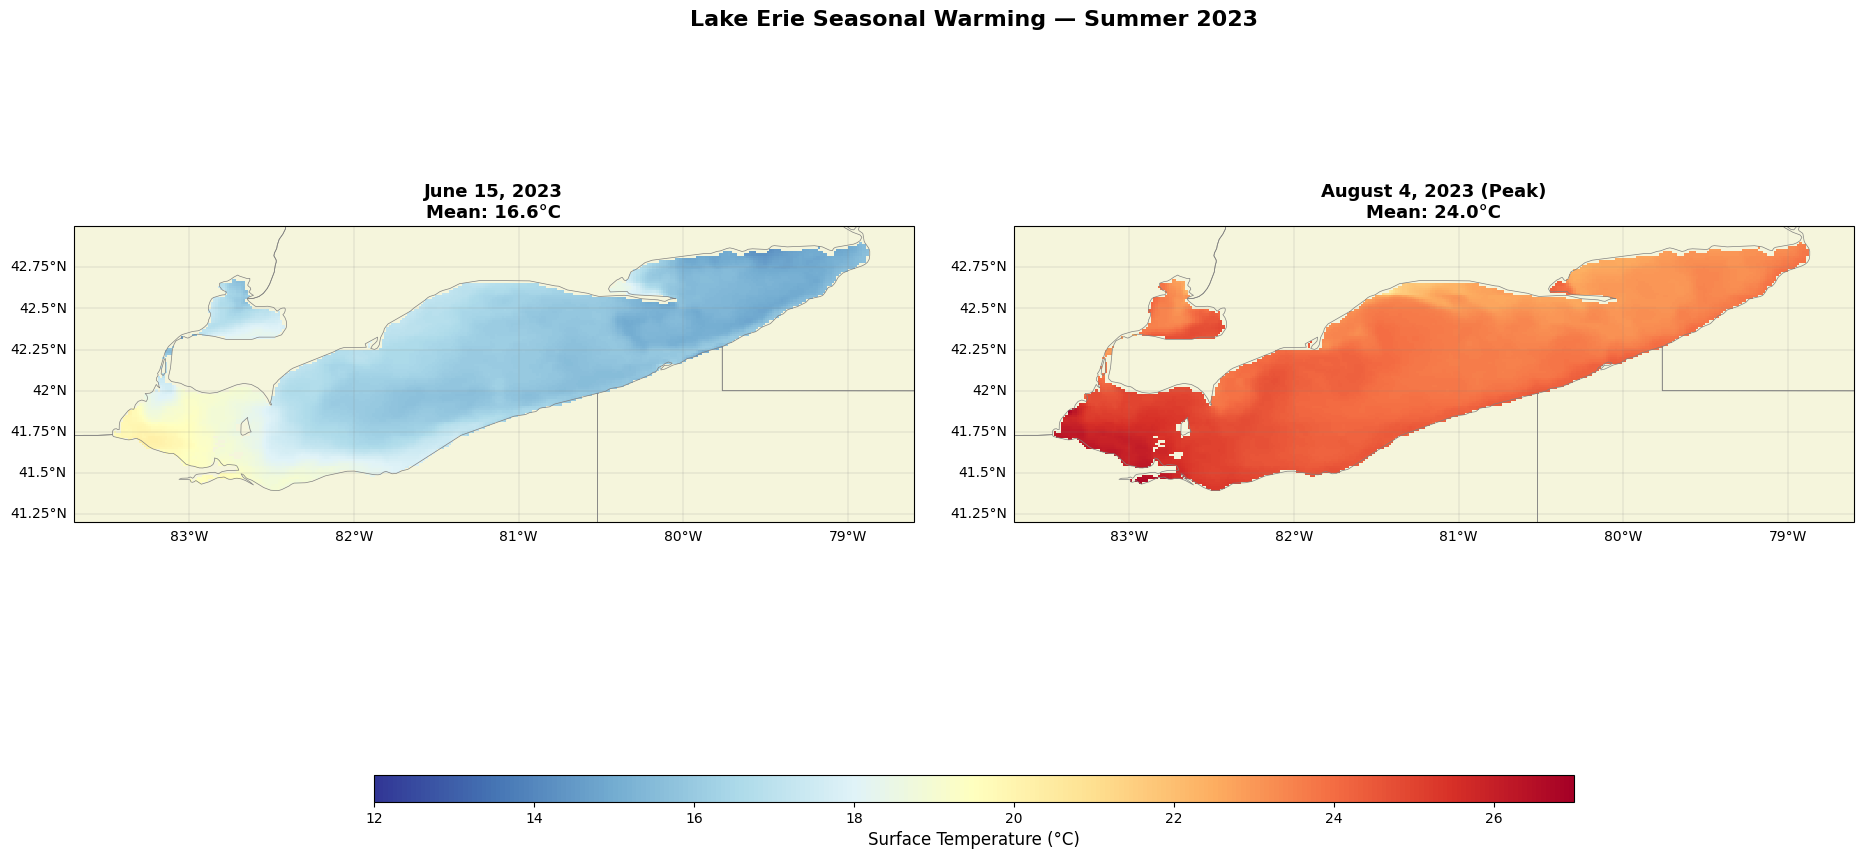


Warming from June to August: +7.4°C lake-wide average


In [5]:
# Select representative days from June and August
june_day = ds.sst.sel(time='2023-06-15', method='nearest')
august_day = ds.sst.sel(time='2023-08-04', method='nearest')

june_date = str(ds.time.sel(time='2023-06-15', method='nearest').values)[:10]
august_date = str(ds.time.sel(time='2023-08-04', method='nearest').values)[:10]

# Create figure with explicit colorbar axes
fig = plt.figure(figsize=(20, 9))

# Manually position: [left, bottom, width, height]
ax1 = fig.add_axes([0.05, 0.25, 0.42, 0.65], projection=ccrs.PlateCarree())
ax2 = fig.add_axes([0.52, 0.25, 0.42, 0.65], projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])

plot_kwargs = dict(
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=12, vmax=27,
    add_colorbar=False
)

# June
june_day.plot(ax=ax1, **plot_kwargs)
ax1.set_title(f'June 15, 2023\nMean: {float(june_day.mean()):.1f}°C',
              fontsize=13, fontweight='bold')

# August
im = august_day.plot(ax=ax2, **plot_kwargs)
ax2.set_title(f'August 4, 2023 (Peak)\nMean: {float(august_day.mean()):.1f}°C',
              fontsize=13, fontweight='bold')

# Map features
for ax in [ax1, ax2]:
    ax.coastlines(resolution='10m', linewidth=1.2)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.LAND, facecolor='#F5F5DC', zorder=0)
    ax.set_extent([LAKE_ERIE['lon_min']-0.2, LAKE_ERIE['lon_max']+0.2,
                   LAKE_ERIE['lat_min']-0.1, LAKE_ERIE['lat_max']+0.1])
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

# Colorbar in its own dedicated space
cbar = fig.colorbar(ax2.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Surface Temperature (°C)', fontsize=12)

fig.suptitle('Lake Erie Seasonal Warming — Summer 2023',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('output/lake_erie_june_vs_august_2023.png', dpi=150, bbox_inches='tight')
plt.show()

temp_change = float(august_day.mean()) - float(june_day.mean())
print(f"\nWarming from June to August: +{temp_change:.1f}°C lake-wide average")

## Step 5: Multi-Year Comparison (2019–2023)

A single summer only tells us what happened in 2023. To understand whether Lake Erie is warming over time — and whether HAB-favorable conditions are increasing — we need to compare multiple years. We'll pull peak summer data (July–August) for the last five years and look for trends.

This is where the analysis shifts from descriptive ("here's what the lake looked like") to diagnostic ("is it getting worse?").

In [6]:
years = [2019, 2020, 2021, 2022, 2023]
yearly_datasets = {}

# Define the base URL clearly
base_url = "https://apps.glerl.noaa.gov/erddap/griddap/GLSEA_GCS.nc"

for year in years:
    filename = f"../data/lake_erie_sst_{year}_jul_aug.nc"

    # 1. Check Cache First
    if os.path.exists(filename) and os.path.getsize(filename) > 1000:
        print(f"{year}: Loading from cache...", end=" ")
        try:
            ds_year = xr.open_dataset(filename, engine="netcdf4")
            yearly_datasets[year] = ds_year
            print(f"OK ({len(ds_year.time)} days)")
            continue
        except Exception as e:
            print(f"Cache corrupted ({e}), re-downloading.")

    # 2. Construct Query URL (Jul 1 - Aug 31)
    # Note: Times are T12:00:00Z to match the daily composite
    query = (
        f"?sst"
        f"[({year}-07-01T12:00:00Z):1:({year}-08-31T12:00:00Z)]"
        f"[({LAKE_ERIE['lat_min']}):1:({LAKE_ERIE['lat_max']})]"
        f"[({LAKE_ERIE['lon_min']}):1:({LAKE_ERIE['lon_max']})]"
    )
    url = base_url + query

    # 3. Fetch with Retry Logic
    print(f"Fetching {year} (Jul-Aug)...", end="", flush=True)

    for attempt in range(1, 4):
        try:
            resp = requests.get(url, timeout=300)

            if resp.status_code == 200:
                # Validate it's a NetCDF, not an HTML error page
                if b'<!DOCTYPE' in resp.content[:100]:
                    print(" Error: Server returned HTML instead of NetCDF.")
                    print(f"Server Says: {resp.text[:200]}")
                    break

                # Save to disk
                with open(filename, "wb") as f:
                    f.write(resp.content)

                # Verify load
                ds_year = xr.open_dataset(filename, engine="netcdf4")
                yearly_datasets[year] = ds_year
                print(f" Success ({len(ds_year.time)} days)")

                # COOL DOWN - Critical for NOAA servers
                time.sleep(15)
                break

            elif resp.status_code == 404:
                # 404 Debugging
                print(f" 404 Not Found.")
                print(f"Debug URL: {url}")
                print(f"Server Message: {resp.text[:300]}") # Print the actual error
                break

            else:
                print(f" Status {resp.status_code}", end="")
                if attempt < 3:
                    print(", retrying...", end="", flush=True)
                    time.sleep(10 * attempt)
                else:
                    print(" Failed.")

        except Exception as e:
            print(f" Error: {e}", end="")
            if attempt < 3:
                time.sleep(5)

# 4. Process Statistics (Only if data loaded)
if len(yearly_datasets) == len(years):
    print("\nAll data successfully loaded.")
else:
    print(f"\nWarning: Only {len(yearly_datasets)} of {len(years)} years loaded. Check errors above.")

2019: Loading from cache... OK (62 days)
2020: Loading from cache... OK (62 days)
2021: Loading from cache... OK (62 days)
2022: Loading from cache... OK (62 days)
2023: Loading from cache... OK (62 days)

All data successfully loaded.


In [7]:
# 4. Process Statistics (Only if data loaded)
yearly_stats = []

print(f"{'Year':<6} {'Mean (°C)':<12} {'Max (°C)':<12} {'Days >20°C':<14} {'Days >24°C':<14}")
print("-" * 65)

for year in years:
    ds_year = yearly_datasets[year]
    daily_mean = ds_year.sst.mean(dim=['latitude', 'longitude'])

    mean_temp = float(daily_mean.mean())
    max_temp = float(ds_year.sst.max())
    days_above_20 = int((daily_mean > 20).sum())
    days_above_24 = int((daily_mean > 24).sum())

    yearly_stats.append({
        'year': year, 'mean': mean_temp, 'max': max_temp,
        'days_above_20': days_above_20, 'days_above_24': days_above_24
    })

    print(f"{year:<6} {mean_temp:<12.1f} {max_temp:<12.1f} {days_above_20:<14} {days_above_24:<14}")

# Store for plotting
stats_df = pd.DataFrame(yearly_stats)

Year   Mean (°C)    Max (°C)     Days >20°C     Days >24°C    
-----------------------------------------------------------------
2019   23.8         27.9         62             32            
2020   24.5         30.0         62             57            
2021   23.6         28.4         62             25            
2022   23.7         27.5         62             35            
2023   23.1         27.0         62             0             


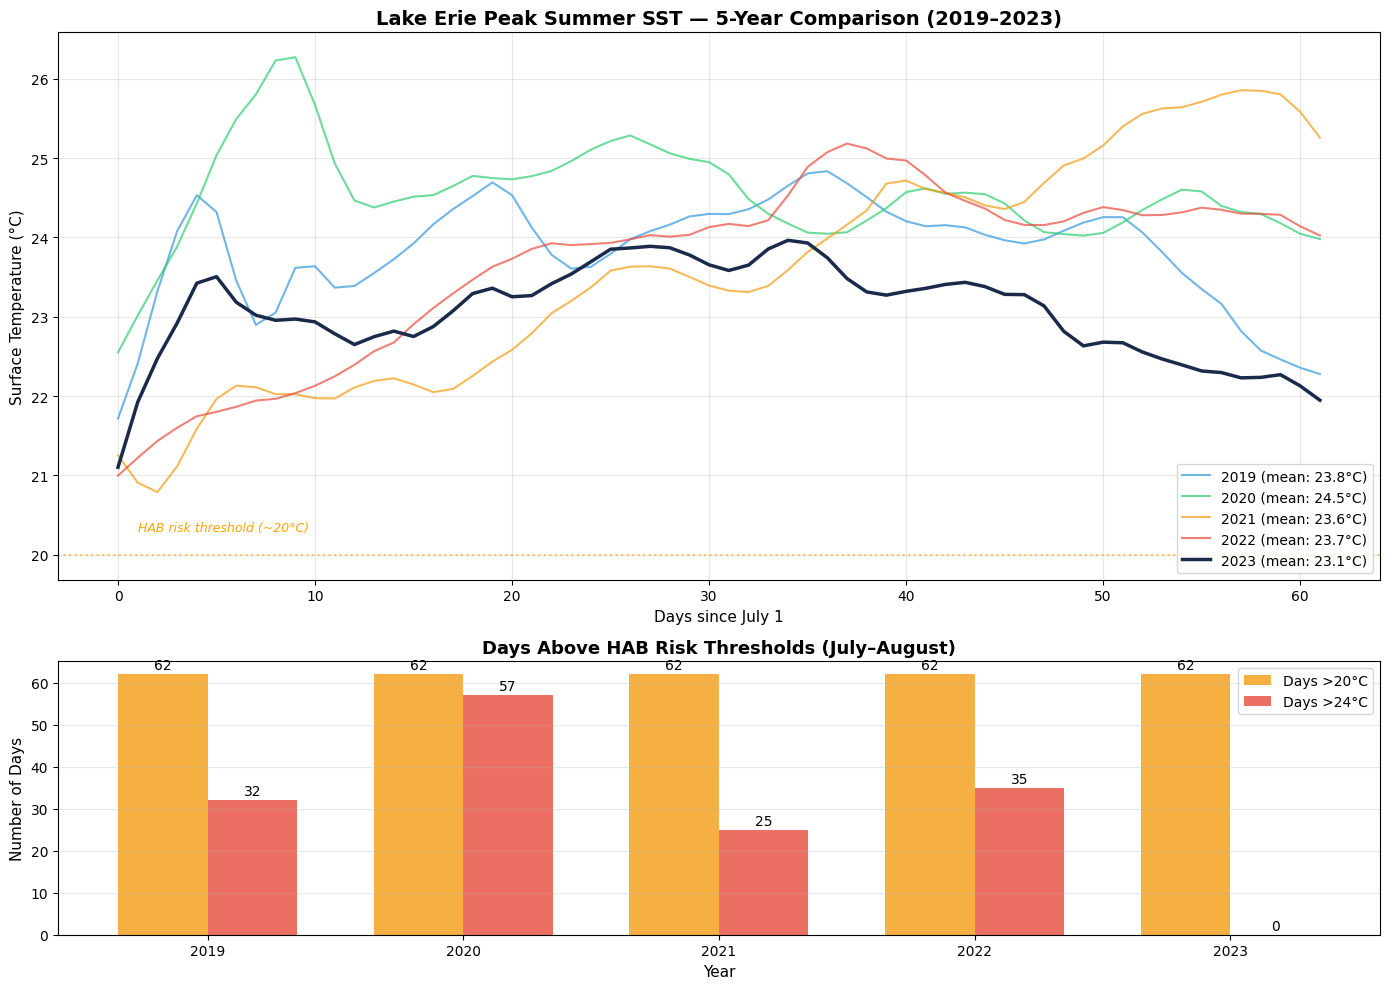

In [8]:
# Multi-year comparison plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Top panel: overlaid temperature curves for each year
colors = ['#3498DB', '#2ECC71', '#F39C12', '#E74C3C', '#1B2A4A']
for i, year in enumerate(years):
    ds_year = yearly_datasets[year]
    daily_mean = ds_year.sst.mean(dim=['latitude', 'longitude'])

    # Create day-of-summer index (0 = July 1) for alignment
    day_index = range(len(daily_mean))

    axes[0].plot(day_index, daily_mean.values, color=colors[i],
                 linewidth=2.5 if year == 2023 else 1.5,
                 alpha=1.0 if year == 2023 else 0.7,
                 label=f'{year} (mean: {float(daily_mean.mean()):.1f}°C)')

axes[0].axhline(y=20, color='orange', linestyle=':', alpha=0.6)
axes[0].text(1, 20.3, 'HAB risk threshold (~20°C)', fontsize=9, color='orange', style='italic')
axes[0].set_xlabel('Days since July 1', fontsize=11)
axes[0].set_ylabel('Surface Temperature (°C)', fontsize=11)
axes[0].set_title('Lake Erie Peak Summer SST — 5-Year Comparison (2019–2023)',
                   fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Bottom panel: bar chart of days above thresholds
x = np.arange(len(years))
width = 0.35

bars1 = axes[1].bar(x - width/2, stats_df['days_above_20'], width,
                     label='Days >20°C', color='#F39C12', alpha=0.8)
bars2 = axes[1].bar(x + width/2, stats_df['days_above_24'], width,
                     label='Days >24°C', color='#E74C3C', alpha=0.8)

axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Number of Days', fontsize=11)
axes[1].set_title('Days Above HAB Risk Thresholds (July–August)',
                   fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(years)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('output/lake_erie_multiyear_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Step 6: Spatial Dynamics - Western vs Eastern Basin

Lake Erie isn't uniform. The shallow West heats up faster than the deep East. We will use the full Summer 2023 dataset (ds) to visualize this thermal lag.

Western Basin Peak: 25.0°C
Eastern Basin Peak: 23.4°C
Max Thermal Difference (West warmer): 3.8°C
Max Thermal Difference (East warmer): -0.2°C


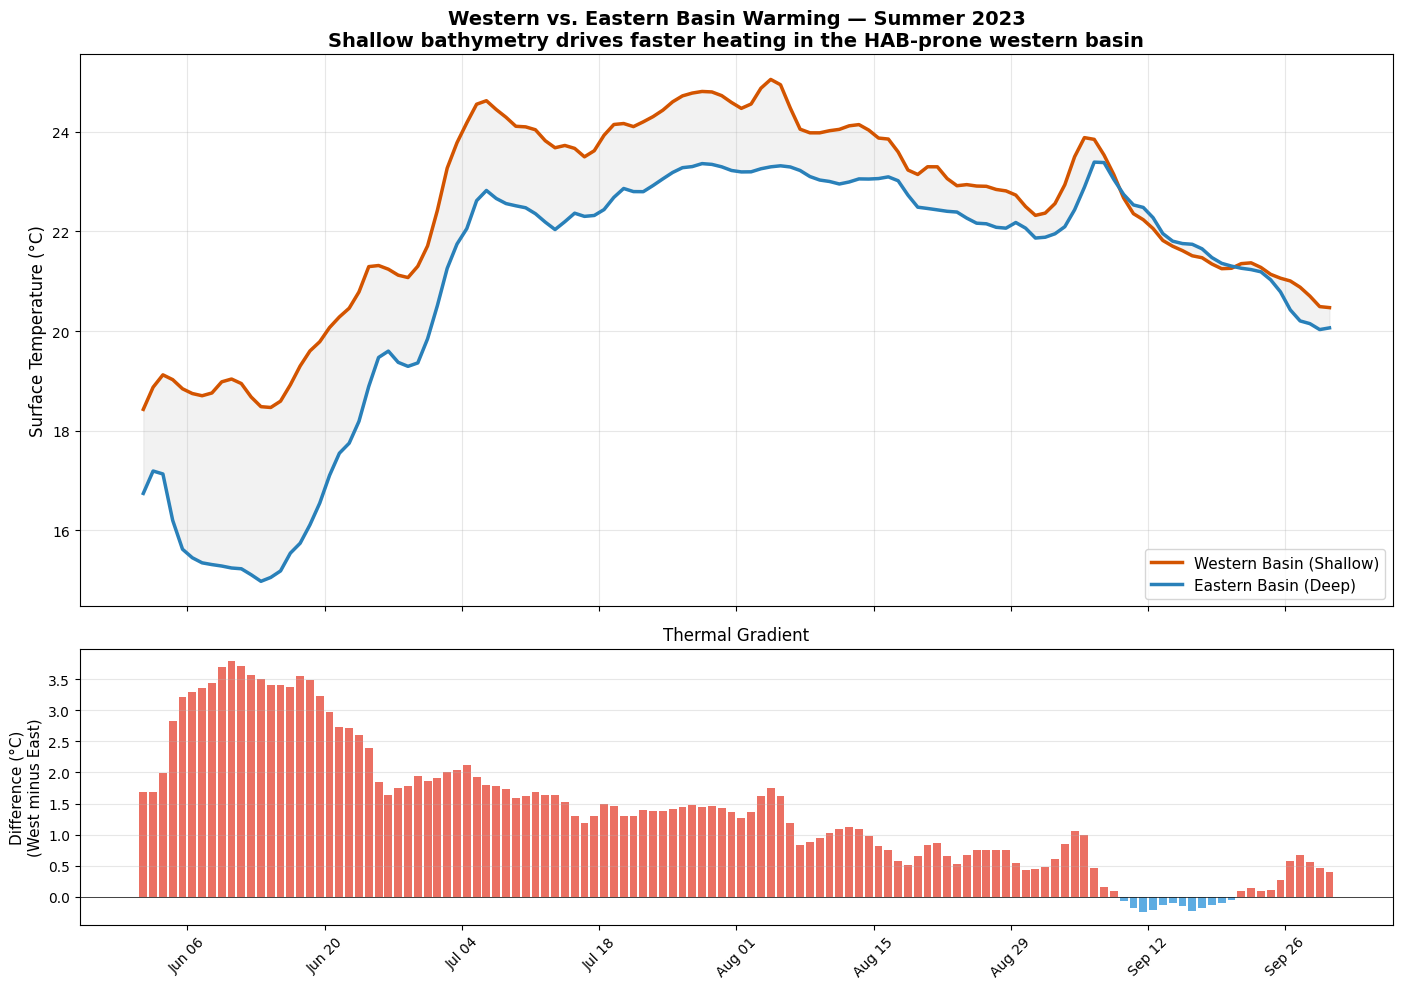

In [9]:
# 1. Define Longitude boundaries for Basins
# Western Basin: West of -82.5°W (The shallow "island" region, avg depth ~7.4m)
# Eastern Basin: East of -80.0°W (The deep region near PA/NY, up to 64m)
# Central Basin (-82.5 to -80.0) is excluded for a clean west-vs-east contrast.
west_mask = ds.longitude < -82.5
east_mask = ds.longitude > -80.0

# 2. Compute spatial averages for each region
# .where() masks out data outside our regions, then we take the spatial mean
west_sst = ds.sst.where(west_mask).mean(dim=['latitude', 'longitude'])
east_sst = ds.sst.where(east_mask).mean(dim=['latitude', 'longitude'])

# 3. Calculate the thermal difference (Gradient)
gradient = west_sst - east_sst

print(f"Western Basin Peak: {float(west_sst.max()):.1f}°C")
print(f"Eastern Basin Peak: {float(east_sst.max()):.1f}°C")
print(f"Max Thermal Difference (West warmer): {float(gradient.max()):.1f}°C")
print(f"Max Thermal Difference (East warmer): {float(gradient.min()):.1f}°C")

# 4. Plot the comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# Top Panel: Temperature Time Series
ax1.plot(dates, west_sst, color='#D35400', linewidth=2.5, label='Western Basin (Shallow)')
ax1.plot(dates, east_sst, color='#2980B9', linewidth=2.5, label='Eastern Basin (Deep)')
ax1.fill_between(dates, west_sst, east_sst, color='gray', alpha=0.1)

ax1.set_ylabel('Surface Temperature (°C)', fontsize=12)
ax1.set_title('Western vs. Eastern Basin Warming — Summer 2023\n'
              'Shallow bathymetry drives faster heating in the HAB-prone western basin',
              fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom Panel: The Gradient
# Positive = West warmer (typical in early summer)
# Negative = East warmer (can occur during late-summer turnover)
gradient_vals = gradient.values
bar_colors = np.where(gradient_vals > 0, '#E74C3C', '#3498DB')
ax2.bar(dates, gradient_vals, color=bar_colors, alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5)

ax2.set_ylabel('Difference (°C)\n(West minus East)', fontsize=11)
ax2.set_title('Thermal Gradient', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Formatting dates
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
ax2.xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('output/lake_erie_basin_comparison_2023.png', dpi=150, bbox_inches='tight')
plt.show()

# Step 7: Temperature Anomaly Map (2023 vs. 2019–2022 Baseline)

An anomaly map shows *where* the lake deviated from its recent average. Rather than plotting raw temperatures, we subtract a 4-year baseline (2019–2022) from 2023, pixel by pixel. Positive values (red) mean warmer than normal; negative values (blue) mean cooler.

This is a standard technique in climate science — it reveals spatial patterns that absolute temperature maps can hide.


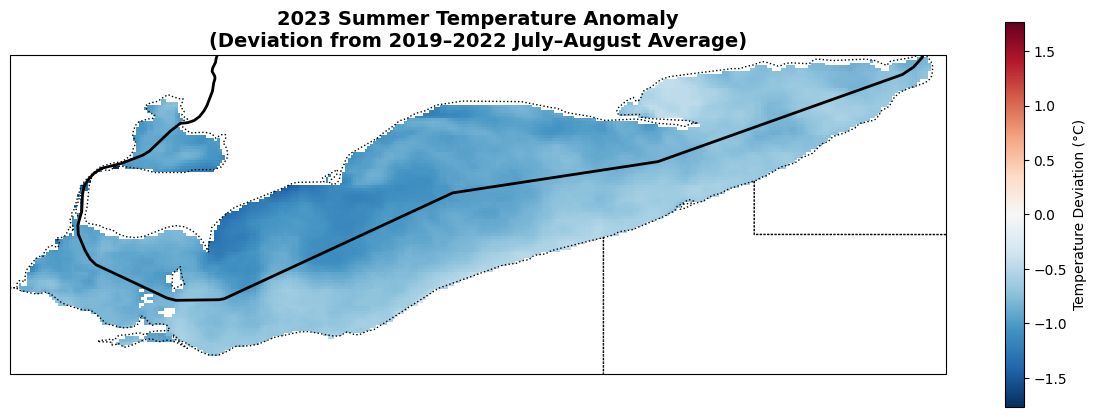

Lake-wide Average Anomaly: -0.84°C
Warmest Anomaly (least cooling): -0.31°C
Coolest Anomaly (most cooling):  -1.77°C

2023 was 0.84°C cooler than the 2019-2022 average across the entire lake.


In [10]:
# 1. Create a "Baseline" by averaging 2019, 2020, 2021, and 2022
# We combine them along a new 'year' dimension and then mean across it
past_years = [yearly_datasets[y].sst for y in [2019, 2020, 2021, 2022]]
baseline = xr.concat(past_years, dim='year').mean(dim=['year', 'time'])

# 2. Get the 2023 Average for the same period (July-August)
current_2023 = yearly_datasets[2023].sst.mean(dim='time')

# 3. Calculate the Anomaly
anomaly = current_2023 - baseline

# 4. Visualization
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use a DIVERGING colormap (RdBu_r) where 0 = white, Red = warmer, Blue = cooler
mesh = anomaly.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='RdBu_r', center=0,
    cbar_kwargs={'label': 'Temperature Deviation (°C)', 'shrink': 0.5}
)

# Add Geography
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.set_extent([-83.5, -78.8, 41.3, 42.9])

plt.title('2023 Summer Temperature Anomaly\n(Deviation from 2019–2022 July–August Average)',
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('output/lake_erie_anomaly_2023.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary — note that 2023 Jul-Aug was cooler than the 4-year baseline everywhere
lake_mean = float(anomaly.mean())
warmest_spot = float(anomaly.max())
coolest_spot = float(anomaly.min())
print(f"Lake-wide Average Anomaly: {lake_mean:+.2f}°C")
print(f"Warmest Anomaly (least cooling): {warmest_spot:+.2f}°C")
print(f"Coolest Anomaly (most cooling):  {coolest_spot:+.2f}°C")
print(f"\n2023 was {abs(lake_mean):.2f}°C cooler than the 2019-2022 average across the entire lake.")


# Step 8: Chlorophyll-a Dataset Discovery

To connect SST patterns to algal blooms, we need biological data. GLERL's ERDDAP server hosts chlorophyll-a concentration maps derived from the VIIRS satellite sensor. Chlorophyll-a is the primary photosynthetic pigment in algae — elevated concentrations indicate bloom activity.

We query the server metadata first to discover the exact variable name, then fetch data for August 15, 2023 (mid-bloom season).


In [11]:
DATASET_ID = "LE_CHL_VIIRS_SQ"
CHL_FILENAME = "../data/lake_erie_chl_2023_aug15.nc"

# Check cache first
if os.path.exists(CHL_FILENAME) and os.path.getsize(CHL_FILENAME) > 1000:
    print(f"Loading chlorophyll data from cache...", end=" ")
    ds_chl = xr.open_dataset(CHL_FILENAME, engine="netcdf4")
    print(f"OK ({len(ds_chl.time)} time slices)")
else:
    INFO_URL = f"https://apps.glerl.noaa.gov/erddap/info/{DATASET_ID}/index.json"
    print(f"Interrogating Dataset: {DATASET_ID}...")

    try:
        # 1. Discover the variable name from the server metadata
        resp = requests.get(INFO_URL, timeout=20)
        if resp.status_code == 200:
            rows = resp.json()['table']['rows']
            vars_found = [row[1] for row in rows if row[0] == 'variable'
                          and row[1] not in ['time', 'lat', 'lon', 'latitude', 'longitude']]

            target_var = vars_found[0]
            print(f"Detected primary variable: {target_var}")

            # 2. Fetch August 15, 2023 data
            BASE_URL = f"https://apps.glerl.noaa.gov/erddap/griddap/{DATASET_ID}.nc"
            query = (
                f"{target_var}[(2023-08-15T00:00:00Z):1:(2023-08-15T23:59:59Z)]"
                "[(41.3):1:(42.9)]"
                "[(-83.5):1:(-78.8)]"
            )

            full_url = f"{BASE_URL}?{query}"
            print(f"Fetching: {full_url}")

            d_resp = requests.get(full_url, timeout=60)
            if d_resp.status_code == 200:
                with open(CHL_FILENAME, "wb") as f:
                    f.write(d_resp.content)
                ds_chl = xr.open_dataset(CHL_FILENAME, engine="netcdf4")
                print(f"\nSUCCESS: Chlorophyll data cached ({len(ds_chl.time)} time slices)")
                print(ds_chl)
            else:
                print(f"Data Fetch Failed (Status {d_resp.status_code})")
                print(f"Server message: {d_resp.text[:300]}")
        else:
            print(f"Could not reach Info endpoint. Status: {resp.status_code}")

    except Exception as e:
        print(f"Pipeline Error: {e}")


Loading chlorophyll data from cache... OK (3 time slices)


# Step 9: Chlorophyll-a Bloom Map

With the biological data in hand, we visualize chlorophyll-a concentration across the lake. A logarithmic color scale is essential — bloom concentrations span orders of magnitude (0.1 to 50+ mg/m³), and a linear scale would wash out the spatial structure.


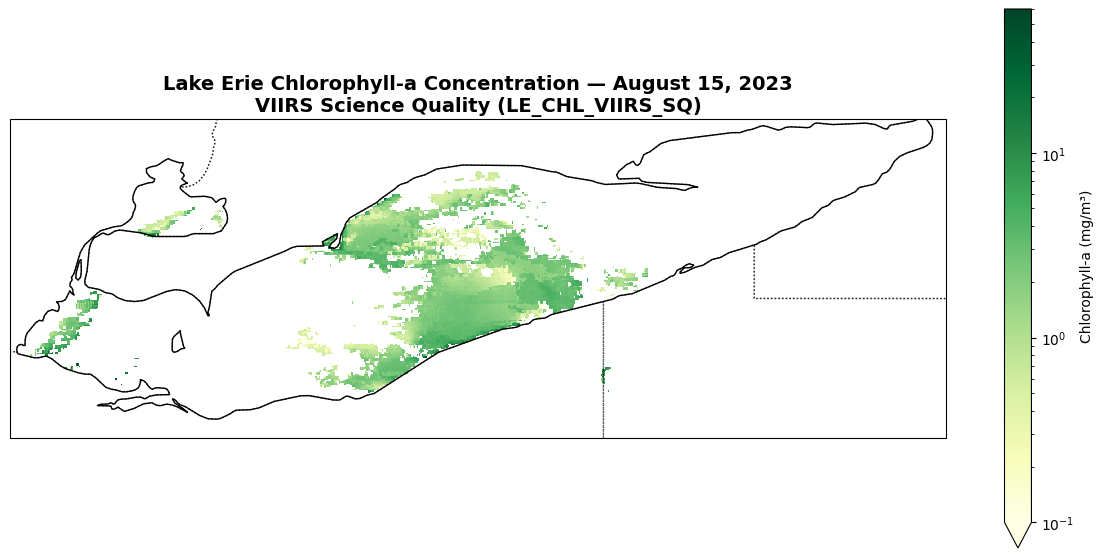

Peak Concentration: 46.76 mg/m³
Mean Concentration: 2.29 mg/m³


In [12]:
if 'ds_chl' in locals():
    # Take the mean of the satellite overpasses for that day to get a clean composite
    chl_map = ds_chl.Chlorophyll.mean(dim='time')

    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Logarithmic scaling captures the 0.1 to 60 mg/m³ range
    im = chl_map.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mcolors.LogNorm(vmin=0.1, vmax=60),
        cmap='YlGn',
        cbar_kwargs={'label': 'Chlorophyll-a (mg/m³)', 'shrink': 0.7}
    )

    # Geography
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.7)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.set_extent([-83.5, -78.8, 41.3, 42.9])

    plt.title('Lake Erie Chlorophyll-a Concentration — August 15, 2023\n'
              'VIIRS Science Quality (LE_CHL_VIIRS_SQ)',
              fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('output/lake_erie_bloom_map.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Peak Concentration: {float(chl_map.max()):.2f} mg/m³")
    print(f"Mean Concentration: {float(chl_map.mean()):.2f} mg/m³")
else:
    print("ERROR: ds_chl not loaded. Run Step 8 first.")


# Step 10: SST–Chlorophyll Spatial Correlation

The key hypothesis: **warm surface water in the shallow western basin drives algal bloom intensity.** By plotting SST and chlorophyll-a side by side for the same date, we can visually assess whether the thermal and biological hotspots overlap.

Both datasets use the Lake Erie bounding box (41.3–42.9°N, -83.5 to -78.8°W). Note that GLSEA SST and VIIRS chlorophyll have different native resolutions, so this is a visual comparison — not a pixel-aligned correlation.

SST date selected: 2023-08-15
GLSEA SST mean: 23.28°C
Chlorophyll peak: 46.76 mg/m³


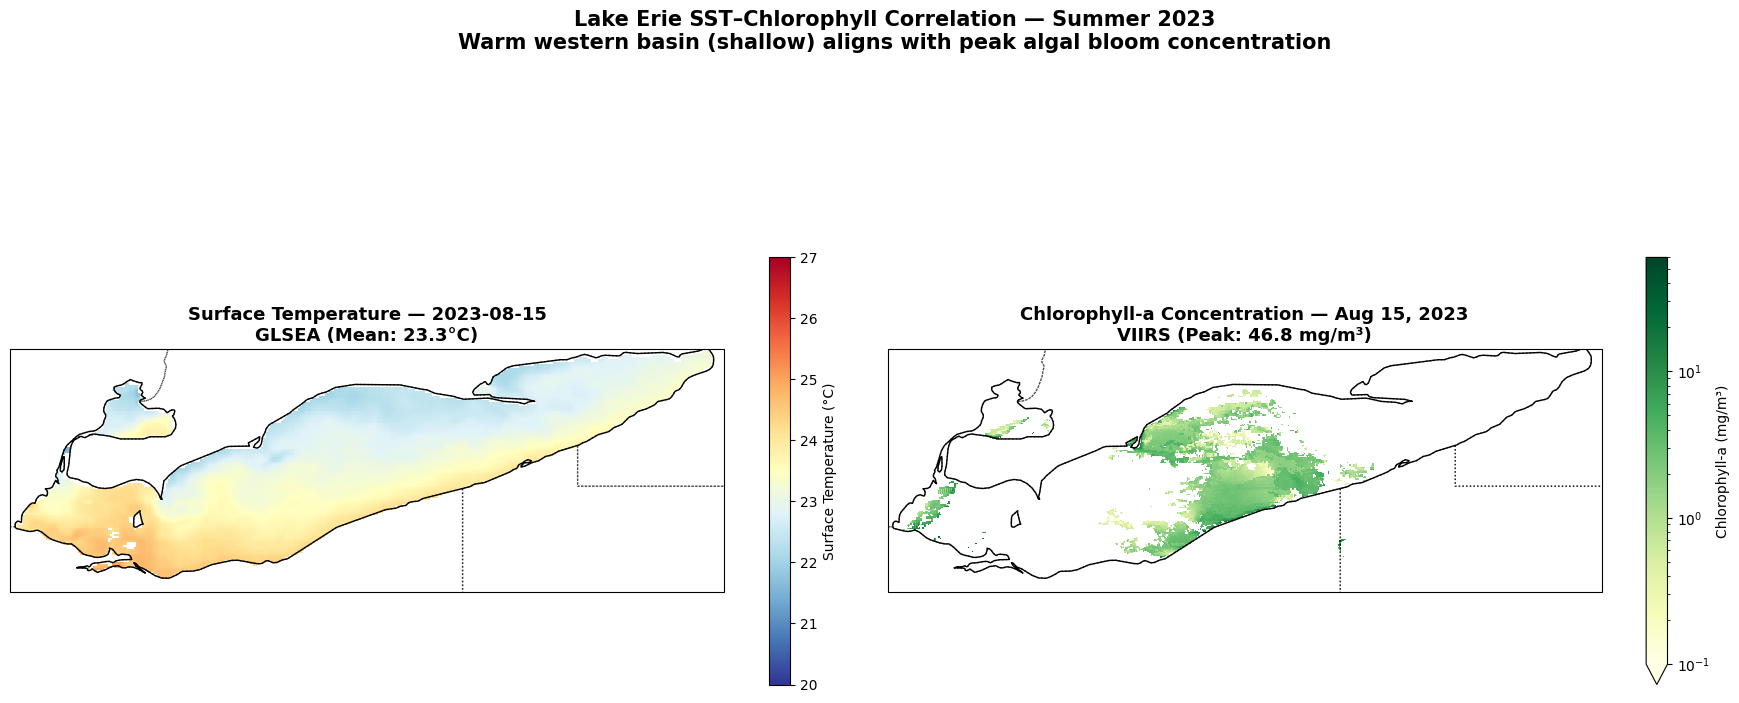


Note: GLSEA grid is (115, 337) (115×337)
      VIIRS grid is (248, 727) (248×727)
      Grids differ in resolution — visual comparison only (not pixel-aligned).


In [13]:
# SST-Chlorophyll Spatial Correlation — August 15, 2023
# Uses GLSEA SST (same dataset as rest of notebook) for consistency

# 1. Get GLSEA SST for August 15, 2023 from our existing summer dataset
sst_aug15 = ds.sst.sel(time='2023-08-15', method='nearest')
sst_date = str(ds.time.sel(time='2023-08-15', method='nearest').values)[:10]
print(f"SST date selected: {sst_date}")
print(f"GLSEA SST mean: {float(sst_aug15.mean()):.2f}°C")

# 2. Chlorophyll data (already loaded as ds_chl)
chl_aug15 = ds_chl.Chlorophyll.mean(dim='time')
print(f"Chlorophyll peak: {float(chl_aug15.max()):.2f} mg/m³")

# 3. Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                                subplot_kw={'projection': ccrs.PlateCarree()})

# Left: SST (Thermal driver)
sst_aug15.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='RdYlBu_r',
               vmin=20, vmax=27,
               cbar_kwargs={'label': 'Surface Temperature (°C)', 'shrink': 0.6})
ax1.set_title(f'Surface Temperature — {sst_date}\n'
              f'GLSEA (Mean: {float(sst_aug15.mean()):.1f}°C)',
              fontsize=13, fontweight='bold')

# Right: Chlorophyll (Biological response)
chl_aug15.plot(ax=ax2, transform=ccrs.PlateCarree(),
               norm=mcolors.LogNorm(vmin=0.1, vmax=60), cmap='YlGn',
               cbar_kwargs={'label': 'Chlorophyll-a (mg/m³)', 'shrink': 0.6})
ax2.set_title('Chlorophyll-a Concentration — Aug 15, 2023\n'
              f'VIIRS (Peak: {float(chl_aug15.max()):.1f} mg/m³)',
              fontsize=13, fontweight='bold')

for ax in [ax1, ax2]:
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.7)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.set_extent([-83.5, -78.8, 41.3, 42.9])

fig.suptitle('Lake Erie SST–Chlorophyll Correlation — Summer 2023\n'
             'Warm western basin (shallow) aligns with peak algal bloom concentration',
             fontsize=15, fontweight='bold', y=1.04)

plt.tight_layout()
plt.savefig('output/lake_erie_sst_chl_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Quick spatial note
print(f"\nNote: GLSEA grid is {sst_aug15.shape} ({sst_aug15.shape[0]}×{sst_aug15.shape[1]})")
print(f"      VIIRS grid is {chl_aug15.shape} ({chl_aug15.shape[0]}×{chl_aug15.shape[1]})")
print("      Grids differ in resolution — visual comparison only (not pixel-aligned).")
